## Context

Banks incur significant losses due to default in loans. This has led to a tightening up of loan underwriting and has increased loan rejection rates. The need for a better credit risk scoring model is also raised by banks.

The CNK bank has collected customer data for the past few years and wants to build a model to predict if a customer coming to purchase a loan is a good customer (will not default) or a bad customer (will default).


## Data Dictionary

- month - the month of purchase
- credit_amount - amount for which loan is requested
- credit_term - for how long customer wants a loan
- age - age of the customer
- sex - gender of the customer
- education - education level of customer
- product_type - for purchasing what type of product does the customer need a loan (0, 1, 2, 3, 4)
- having_children_flg - if the customer has children or not
- region - customer region category(0, 1, 2)
- income - income of the customer
- family_status - another, married, unmarried
- phone_operator - mobile operator category(0, 1, 2, 3)
- is_client - if the customer wanting to purchase a loan is our client or not
- target - 1-bad customer, 0-good customer

## Imblearn installation

In [ ]:
# Imblearn libary is used to handle imbalanced data

# Jupyter notebook
!pip install imblearn --user

!pip install imbalanced-learn --user

# Anaconda prompt
#!pip install -U imbalanced-learn

#conda install -c conda-forge imbalanced-learn

# Restart the kernel after successful installation of the library

## Import Libraries

In [ ]:
# To help with reading and manipulation of data
import numpy as np
from numpy import array
import pandas as pd

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer

# To do one-hot encoding
from sklearn.preprocessing import OneHotEncoder

# To build a decision tree model
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)


# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Load and view dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [ ]:
df = pd.read_csv("Loanclients.csv")

In [ ]:
data = df.copy()

In [ ]:
data.head()

,Month,credit_amount,credit_term,Age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,target
0,10,7000,6,25,0,Secondary special education,1,0,0,21000.0,1,0,0,0
1,10,19000,3,54,0,Secondary special education,3,1,1,17000.0,1,3,0,0
2,1,29000,2,36,0,Secondary special education,1,0,2,31000.0,1,2,0,0
3,11,10000,6,46,0,Secondary special education,0,1,1,31000.0,1,3,0,0
4,4,14500,4,39,0,Higher education,1,0,1,26000.0,1,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Month                1000 non-null   int64  
 1   credit_amount        1000 non-null   int64  
 2   credit_term          1000 non-null   int64  
 3   Age                  1000 non-null   int64  
 4   sex                  1000 non-null   int64  
 5   education            1000 non-null   object 
 6   product_type         1000 non-null   int64  
 7   having_children_flg  1000 non-null   int64  
 8   region               1000 non-null   int64  
 9   income               967 non-null    float64
 10  family_status        1000 non-null   int64  
 11  phone_operator       1000 non-null   int64  
 12  is_client            1000 non-null   int64  
 13  target               1000 non-null   int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 109.5+ KB


In [ ]:
data.head()

,Month,credit_amount,credit_term,Age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,target
0,10,7000,6,25,0,Secondary special education,1,0,0,21000.0,1,0,0,0
1,10,19000,3,54,0,Secondary special education,3,1,1,17000.0,1,3,0,0
2,1,29000,2,36,0,Secondary special education,1,0,2,31000.0,1,2,0,0
3,11,10000,6,46,0,Secondary special education,0,1,1,31000.0,1,3,0,0
4,4,14500,4,39,0,Higher education,1,0,1,26000.0,1,0,0,0


#### Let's look at the pairplot of the data

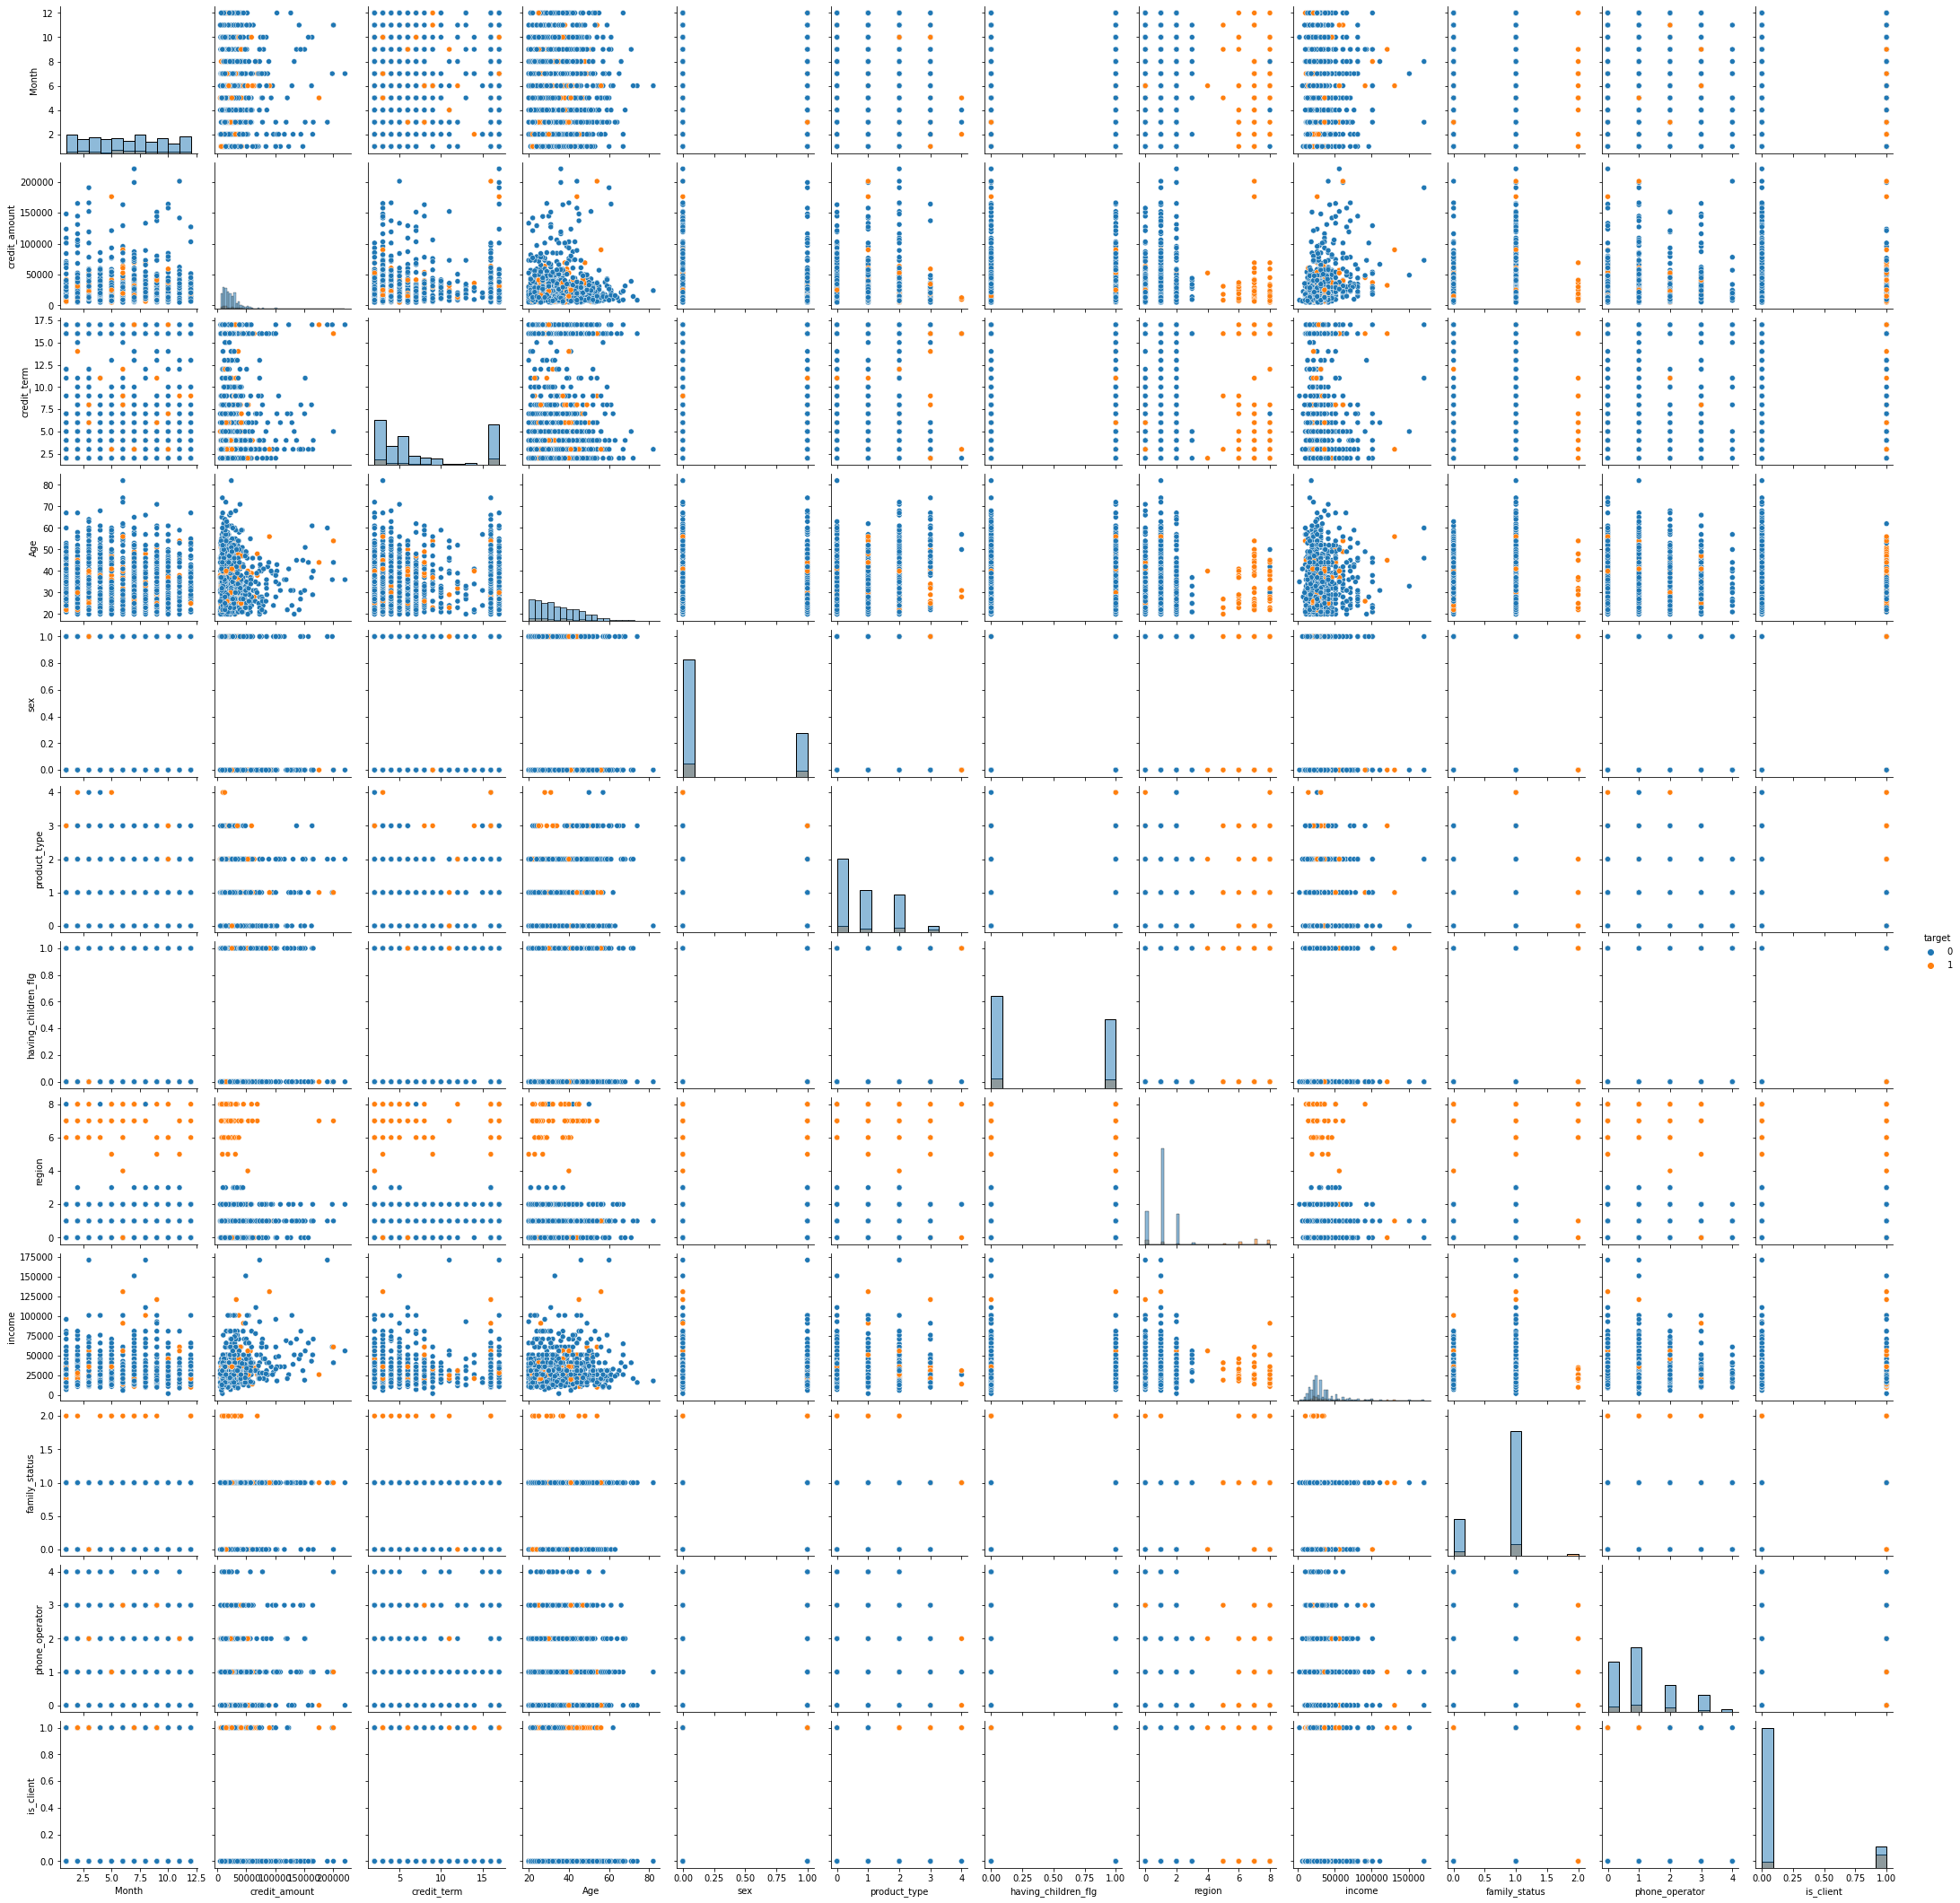

In [ ]:
sns.pairplot(data, hue = 'target' , diag_kind='hist')

In [ ]:
# checking missing values in the data
data.isna().sum()

Month                   0
credit_amount           0
credit_term             0
Age                     0
sex                     0
education               0
product_type            0
having_children_flg     0
region                  0
income                 33
family_status           0
phone_operator          0
is_client               0
target                  0
dtype: int64

**The income variable has some missing values, we will impute them later**

In [ ]:
data["phone_operator"] = data["phone_operator"].astype("category")
data["product_type"] = data["product_type"].astype("category")
data["education"] = data["education"].astype("category")

In [ ]:
# checking the distribution of the target variable
data["target"].value_counts(1)

0    0.893
1    0.107
Name: target, dtype: float64

### Splitting the data into X and y

In [ ]:
# separating the independent and dependent variables
X = data.drop(["target"], axis=1)
y = data["target"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Splitting data into training, validation and test set:

# first we split data into 2 parts, say temporary and test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, random_state=0, stratify=y
)

# then we split the temporary set into train and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, random_state=0, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)

(500, 23) (300, 23) (200, 23)


In [ ]:
# Let's impute the missing values
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")

# fit the imputer on train data and transform the train data
X_train["income"] = imp_median.fit_transform(X_train[["income"]])

# transform the validation and test data using the imputer fit on train data
X_val["income"] = imp_median.transform(X_val[["income"]])
X_test["income"] = imp_median.transform(X_test[["income"]])

In [ ]:
# Checking class balance for whole data, train set, validation set, and test set

print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_val")
print(y_val.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
0    0.893
1    0.107
Name: target, dtype: float64
********************************************************************************
Target value ratio in y_train
0    0.892
1    0.108
Name: target, dtype: float64
********************************************************************************
Target value ratio in y_val
0    0.893333
1    0.106667
Name: target, dtype: float64
********************************************************************************
Target value ratio in y_test
0    0.895
1    0.105
Name: target, dtype: float64
********************************************************************************


## Model evaluation criterion


**What does a bank want?**
* A bank wants to minimize the loss - it can face 2 types of losses here: 
   * Whenever a bank lends money to a customer, they don't return it.
   * A bank doesn't lend money to a customer thinking a customer will default but in reality, the customer won't - opportunity loss.

**Which loss is greater ?**
* Lending to a customer who wouldn't be able to pay back.

**Since we want to reduce loan defaults we should use Recall as a metric of model evaluation instead of accuracy.**

* Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a bad customer as a good customer.


## Let's train a decision tree and check it's performance

In [ ]:
dtree = DecisionTreeClassifier(random_state=1, max_depth=4)

# training the decision tree model with oversampled training set
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
print(pd.DataFrame(dtree.feature_importances_, columns = ["imp"], index = X_train.columns))

                                               imp
Month                                     0.000000
credit_amount                             0.000000
credit_term                               0.018772
Age                                       0.000000
sex                                       0.000000
having_children_flg                       0.000000
region                                    0.656550
income                                    0.043484
family_status                             0.182609
is_client                                 0.078218
education_Incomplete higher education     0.000000
education_Incomplete secondary education  0.000000
education_PhD degree                      0.000000
education_Secondary education             0.000000
education_Secondary special education     0.000000
product_type_1                            0.000000
product_type_2                            0.000000
product_type_3                            0.001595
product_type_4                 

#### We have trained the model, Let's check the performance on the oversampled train and validation sets

In [ ]:
# Predicting the target for train and validation set
pred_train = dtree.predict(X_train)
pred_val = dtree.predict(X_val)

In [ ]:
# Checking recall score on oversampled train and validation set
print(recall_score(y_train, pred_train))
print(recall_score(y_val, pred_val))

0.8333333333333334
0.5


In [ ]:
# Checking accuracy score on oversampled train and validation set
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_val, pred_val))

0.982
0.9466666666666667


- Accuracy of the model is good but the metric of interest in Recall here.
- The model's recall score is poor for both train and validation sets.

- Let's try oversampling and undersampling techniques to see if recall improves.

# Oversampling and Undersampling the train data

## Oversampling train data using SMOTE

In [ ]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print("Before OverSampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, count of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, count of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of label '1': 54
Before OverSampling, count of label '0': 446 

After OverSampling, count of label '1': 178
After OverSampling, count of label '0': 446 

After OverSampling, the shape of train_X: (624, 23)
After OverSampling, the shape of train_y: (624,) 



#### Let's train a decision tree classifier using the oversampled data

In [ ]:
dtree1 = DecisionTreeClassifier(random_state=1, max_depth=4)

# training the decision tree model with oversampled training set
dtree1.fit(X_train_over, y_train_over)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

#### We have trained the model, Let's check the performance on the oversampled train and validation sets

In [ ]:
# Predicting the target for train and validation set
pred_train = dtree1.predict(X_train_over)
pred_val = dtree1.predict(X_val)

In [ ]:
# Checking recall score on oversampled train and validation set
print(recall_score(y_train_over, pred_train))
print(recall_score(y_val, pred_val))

0.9550561797752809
0.8125


In [ ]:
# Checking accuracy score on oversampled train and validation set
print(accuracy_score(y_train_over, pred_train))
print(accuracy_score(y_val, pred_val))

0.9727564102564102
0.9666666666666667


#### After checking the performance, let's look at the confusion matrices of the train and validation data

Text(42.0, 0.5, 'Actual Values')

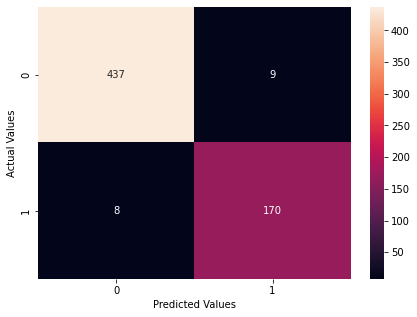

In [ ]:
# Confusion matrix for oversampled train data
cm = confusion_matrix(y_train_over, pred_train)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")


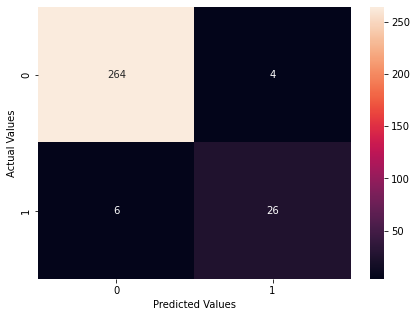

In [ ]:
# Confusion matrix for validation data
cm = confusion_matrix(y_val, pred_val)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

* We can see that the model with oversampled data has improved the train recall from 57% to 92% and 50% to 84% on the validation data
* There is a little overfitting in the results which can be handled separately by using regularization techniques.

## Undersampling train data using Random Undersampler

In [ ]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("Before Under Sampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before Under Sampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, count of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, count of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, count of label '1': 54
Before Under Sampling, count of label '0': 446 

After Under Sampling, count of label '1': 54
After Under Sampling, count of label '0': 54 

After Under Sampling, the shape of train_X: (108, 23)
After Under Sampling, the shape of train_y: (108,) 



#### Let's train a decision tree classifier using the undersampled data

In [ ]:
dtree2 = DecisionTreeClassifier(random_state=1, max_depth=4)

# training the decision tree model with oversampled training set
dtree2.fit(X_train_un, y_train_un)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

#### We have trained the model, let's check the performance on undersampled train and validation data

In [ ]:
# Predicting the target for train and validation set
pred_train = dtree2.predict(X_train_un)
pred_val = dtree2.predict(X_val)

In [ ]:
# Checking recall score on oversampled train and validation set
print(recall_score(y_train_un, pred_train))
print(recall_score(y_val, pred_val))

0.9074074074074074
0.90625


In [ ]:
# Checking accuracy score on undersampled train and validation set
print(accuracy_score(y_train_un, pred_train))
print(accuracy_score(y_val, pred_val))

0.9537037037037037
0.95


#### After checking the performance, let's look at the confusion matrices of the train and validation data

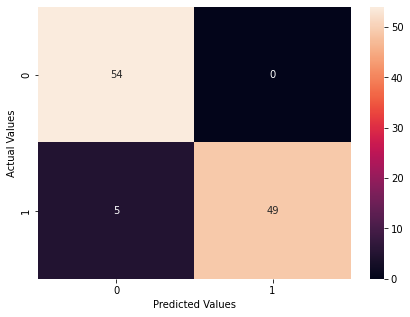

In [ ]:
# Confusion matrix for undersampled train data
cm = confusion_matrix(y_train_un, pred_train)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

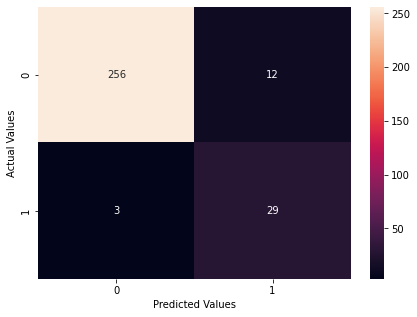

In [ ]:
# Confusion matrix for validation data
cm = confusion_matrix(y_val, pred_val)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

- We can see that the model with undersampled data has improved the train recall from 57% to 88%  and 50% to 84% on the validation data, but the accuracy decreases.

#### We can see that the model trained with undersampled data has better performance, so let's now check the performance of dtree2 using the test data

0.8095238095238095


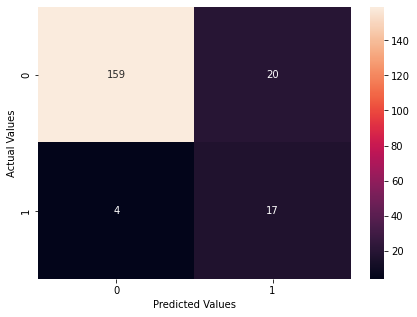

In [ ]:
# Now we have identified the best model, let's check its performance on test set
print(recall_score(y_test, dtree2.predict(X_test)))

cm = confusion_matrix(y_test, dtree2.predict(X_test))
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

* The recall score for the best model on the test data is ~90%

**Further performance can be improved by using hyperparameter tuning**